# Exercise 2: Finite State Transductors
Dartmouth College, LING48, Spring 2021
Ari Chadda, Rolando Coto-Solano 
Updated 4/11/21

This program uses the `openfst` and `graphviz` packages:<br>
http://www.openfst.org/twiki/bin/view/FST/PythonExtension<br>
https://graphviz.readthedocs.io/en/stable/manual.html. 

These packages are used to generate Finite State Transistors to parse word inputs and then change their morphology or translate those words.

(1) First, we have the `fstSymbols`. This is the list of all of the elements you are going to have in the FST. (Practical advice: Make your transitions on paper first, and THEN figure out the symbols as you go).

(2) Second, we have a list of compiler instructions. This is the list of all the transitions and final states in the FST.

(3) Third, we have the `spellout` function. This function has the string as its input, and then goes character by character, calculating the path through the FST and its corresponding transformations.

(4) Finally, we have a function that prints the FST into a PDF so you can see the transitions graphically. (You do not need to modify this)

Step 1: Install the necessary packages.

The `openfst` package is used to create FST and the `graphviz` to display them. 

In [13]:
!pip install openfst-python
!pip install graphviz

Step 2: Load packages

In [2]:
import openfst_python as fst
from graphviz import render
from google.colab import files

Step 3: The following four functions (`linear_fst`, `apply_fst`, `accepted`, `spellout`) carry out the FST processing. You do NOT need to modify them. They come from the [OpenFST tutorials](http://www.openfst.org/twiki/bin/view/FST/FstExamples).

In [3]:
def linear_fst(elements, automata_op, keep_isymbols=True, **kwargs):
    """Produce a linear automata."""
    compiler = fst.Compiler(isymbols=automata_op.input_symbols().copy(), 
                            acceptor=keep_isymbols,
                            keep_isymbols=keep_isymbols, 
                            **kwargs)

    for i, el in enumerate(elements):
        print("{} {} {}".format(i, i+1, el),file=compiler)
    print(str(i+1),file=compiler)

    return compiler.compile()

def apply_fst(elements, automata_op, is_project=True, **kwargs):
    """Compose a linear automata generated from `elements` with `automata_op`.

    Args:
        elements (list): ordered list of edge symbols for a linear automata.
        automata_op (Fst): automata that will be applied.
        is_project (bool, optional): whether to keep only the output labels.
        kwargs:
            Additional arguments to the compiler of the linear automata .
    """
    linear_automata = linear_fst(elements, automata_op, **kwargs)
    out = fst.compose(linear_automata, automata_op)
    if is_project:
        out.project(project_output=True)
    return out

def accepted(output_apply):
    """Given the output of `apply_fst` for acceptor, return True is sting was accepted."""
    return output_apply.num_states() != 0

def spellout(inputString, inSymbols, inFST):
	output=""
	currentFST = apply_fst(list(inputString), inFST)
	for state in currentFST.states():
		for arc in currentFST.arcs(state):
			if (inSymbols.find(arc.olabel) != "<eps>"):
				output += inSymbols.find(arc.olabel)
	return output

Step 4: List of symbols for translation table

Add all the strings in each of the two trees to the symbol table. `<eps>` is for the "look ahead." The translation table also includes the verb state suffix for each.

In [4]:
morphSymbols = fst.SymbolTable()
morphSymbols.add_symbol("<eps>", 0)
morphSymbols.add_symbol("a", 1)
morphSymbols.add_symbol("l", 2)
morphSymbols.add_symbol("e", 3)
morphSymbols.add_symbol("H", 4)
morphSymbols.add_symbol("-e", 5)
morphSymbols.add_symbol("i", 6)
morphSymbols.add_symbol("'", 7)
morphSymbols.add_symbol("o", 8)
morphSymbols.add_symbol("-o", 9)
morphSymbols.add_symbol("q", 10)
morphSymbols.add_symbol("F", 11)
morphSymbols.add_symbol("k", 12)
morphSymbols.add_symbol("a'", 13)
morphSymbols.add_symbol("u", 14)
morphSymbols.add_symbol("x", 15)
morphSymbols.add_symbol("r", 16)
morphSymbols.add_symbol("n", 17)
morphSymbols.add_symbol("-e", 18)
morphSymbols.add_symbol("-u", 19)
morphSymbols.add_symbol("-a", 20)
morphSymbols.add_symbol("-i", 21)
morphSymbols.add_symbol("t", 22)
morphSymbols.add_symbol("s", 23)
morphSymbols.add_symbol("b", 24)

24

In [5]:
translateSymbols = fst.SymbolTable()
translateSymbols.add_symbol("<eps>", 0)
translateSymbols.add_symbol("a", 1)
translateSymbols.add_symbol("l", 2)
translateSymbols.add_symbol("cook", 3)
translateSymbols.add_symbol("e", 4)
translateSymbols.add_symbol("H", 5)
translateSymbols.add_symbol("-IPFV", 6)
translateSymbols.add_symbol("'", 7)
translateSymbols.add_symbol("-THEME.PFV.IMPROSP", 8)
translateSymbols.add_symbol("o", 9)
translateSymbols.add_symbol("q", 10)
translateSymbols.add_symbol("F", 11)
translateSymbols.add_symbol("k", 12)
translateSymbols.add_symbol("-INF", 13)
translateSymbols.add_symbol("-IMP", 14)
translateSymbols.add_symbol("u", 15)
translateSymbols.add_symbol("x", 16)
translateSymbols.add_symbol("-DESIDERATIVE", 17)
translateSymbols.add_symbol("i", 18)
translateSymbols.add_symbol("r", 19)
translateSymbols.add_symbol("-THEME.MID.IPFV", 20)
translateSymbols.add_symbol("n", 21)
translateSymbols.add_symbol("-THEME.MID-PFV.IMPROSP", 22)
translateSymbols.add_symbol("-THEME.MID-INF", 23)
translateSymbols.add_symbol("t", 24)
translateSymbols.add_symbol("s", 25)
translateSymbols.add_symbol("b", 26)
translateSymbols.add_symbol("pop", 27)
translateSymbols.add_symbol("dig", 28)

28

Step 5: Builds the transitions of the FSTs. Each block corresponds to a sub-FST to parse a specific input.

In [6]:
compiler = fst.Compiler(isymbols=morphSymbols, osymbols=morphSymbols, keep_isymbols=True, keep_osymbols=True)

print("0 1 a a",file=compiler)
print("1 2 l l",file=compiler)
print("2 3 e -e",file=compiler)
print("3 4 H H",file=compiler)
print("4",file=compiler)

print("2 5 i -i",file=compiler)
print("5 24 ' '",file=compiler)
print("24",file=compiler)

print("2 6 o -o",file=compiler)
print("6 7 q q",file=compiler)
print("7 8 F F",file=compiler)
print("8 9 <eps> <eps>",file=compiler)
print("9",file=compiler)

print("8 10 k k",file=compiler)
print("10",file=compiler)

print("2 11 a -a",file=compiler)
print("11 12 ' '",file=compiler)
print("12 13 k k",file=compiler)
print("13 14 u u",file=compiler)
print("14 15 x x",file=compiler)
print("15",file=compiler)

print("5 16 H H",file=compiler)
print("16 17 r r",file=compiler)
print("17",file=compiler)

print("16 18 n n",file=compiler)
print("18 19 e -e",file=compiler)
print("19 20 x x",file=compiler)
print("20",file=compiler)

print("18 21 u -u",file=compiler)
print("21 22 x x",file=compiler)
print("22 23 k k",file=compiler)
print("23",file=compiler)

print("0 25 t t",file=compiler)
print("25 26 s s",file=compiler)
print("26 27 a a",file=compiler)
print("27 2 k k",file=compiler)

print("0 33 b b",file=compiler)
print("33 2 i i",file=compiler)

morphFST = compiler.compile()

In [7]:
compiler = fst.Compiler(isymbols=translateSymbols, osymbols=translateSymbols, keep_isymbols=True, keep_osymbols=True)

print("0 1 a <eps>",file=compiler)
print("1 2 l cook",file=compiler)
print("2 3 e <eps>",file=compiler)
print("3 4 H -IPFV",file=compiler)
print("4",file=compiler)

print("2 5 i <eps>",file=compiler)
print("5 24 ' -THEME.PFV.IMPROSP",file=compiler)
print("24",file=compiler)

print("2 6 o <eps>",file=compiler)
print("6 7 q <eps>",file=compiler)
print("7 8 F <eps>",file=compiler)
print("8 9 k -INF",file=compiler)
print("9",file=compiler)

print("8 10 <eps> -IMP",file=compiler)
print("10",file=compiler)

print("2 11 a <eps>",file=compiler)
print("11 12 ' <eps>",file=compiler)
print("12 13 k <eps>",file=compiler)
print("13 14 u <eps>",file=compiler)
print("14 15 x -DESIDERATIVE",file=compiler)
print("15",file=compiler)

print("5 16 H <eps>",file=compiler)
print("16 17 r -THEME.MID.IPFV",file=compiler)
print("17",file=compiler)

print("16 18 n <eps>",file=compiler)
print("18 19 e <eps>",file=compiler)
print("19 20 x -THEME.MID-PFV.IMPROSP",file=compiler)
print("20",file=compiler)

print("18 21 u <eps>",file=compiler)
print("21 22 x <eps>",file=compiler)
print("22 23 k -THEME.MID-INF",file=compiler)
print("23",file=compiler)

print("0 25 t <eps>",file=compiler)
print("25 26 s <eps>",file=compiler)
print("26 27 a <eps>",file=compiler)
print("27 2 k pop",file=compiler)

print("0 33 b <eps>",file=compiler)
print("33 2 i dig",file=compiler)


translateFST = compiler.compile()

Step 6: The grading testing code to test the morphological and translation trees.

In [8]:
print("First you'll see the expected output, and then the output of the student\n")

print("01. Input:       aleH (\"I cook\")\n    Morphs:      al-eH / " + spellout("aleH", morphSymbols, morphFST) + "\n    Translation: cook-IPFV / " + spellout("aleH", translateSymbols, translateFST) + "\n")
print("02. Input:       ali' (\"I cooked\")\n    Morphs:      al-i' / " + spellout("ali'", morphSymbols, morphFST) + "\n    Translation: cook-THEME.PFV.IMPROSP / " + spellout("ali'", translateSymbols, translateFST) + "\n")
print("03. Input:       aloqFk (\"to cook\")\n    Morphs:      al-oqFk / " + spellout("aloqFk", morphSymbols, morphFST) + "\n    Translation: cook-INF / " + spellout("aloqFk", translateSymbols, translateFST) + "\n")
print("04. Input:       aloqF (\"Cook!\")\n    Morphs:      al-oqF / " + spellout("aloqF", morphSymbols, morphFST) + "\n    Translation: cook-IMP / " + spellout("aloqF", translateSymbols, translateFST) + "\n")
print("05. Input:       ala'kux (\"I want to cook\")\n    Morphs:      al-a'kux / " + spellout("ala'kux", morphSymbols, morphFST) + "\n    Translation: cook-DESIDERATIVE / " + spellout("ala'kux", translateSymbols, translateFST) + "\n")
print("15. Input:       aliHr (\"It is being cooked\")\n    Morphs:      al-iHr / " + spellout("aliHr", morphSymbols, morphFST) + "\n    Translation: cook-THEME.MID.IPFV / " + spellout("aliHr", translateSymbols, translateFST) + "\n")
print("16. Input:       aliHnex (\"It became cooked\")\n    Morphs:      al-iHn-ex / " + spellout("aliHnex", morphSymbols, morphFST) + "\n    Translation: cook-THEME.MID-PFV.IMPROSP / " + spellout("aliHnex", translateSymbols, translateFST) + "\n")
print("17. Input:       aliHnuxk (\"to be cooked\")\n    Morphs:      al-iHn-uxk / " + spellout("aliHnuxk", morphSymbols, morphFST) + "\n    Translation: cook-THEME.MID-INF / " + spellout("aliHnuxk", translateSymbols, translateFST) + "\n")

print("03. Input:       tsakoqFk (\"to pop (a bubble), to puncture an object\")\n    Morphs:      tsak-oqFk / " + spellout("tsakoqFk", morphSymbols, morphFST) + "\n    Translation: pop-INF / " + spellout("tsakoqFk", translateSymbols, translateFST) + "\n")
print("03. Input:       bioqFk (\"to dig, to make a hole in the ground\")\n    Morphs:      bi-oqFk / " + spellout("bioqFk", morphSymbols, morphFST) + "\n    Translation: dig-INF / " + spellout("bioqFk", translateSymbols, translateFST) + "\n")


First you'll see the expected output, and then the output of the student

01. Input:       aleH ("I cook")
    Morphs:      al-eH / al-eH
    Translation: cook-IPFV / cook-IPFV

02. Input:       ali' ("I cooked")
    Morphs:      al-i' / al-i'
    Translation: cook-THEME.PFV.IMPROSP / cook-THEME.PFV.IMPROSP

03. Input:       aloqFk ("to cook")
    Morphs:      al-oqFk / al-oqFk
    Translation: cook-INF / cook-INF

04. Input:       aloqF ("Cook!")
    Morphs:      al-oqF / al-oqF
    Translation: cook-IMP / cook-IMP

05. Input:       ala'kux ("I want to cook")
    Morphs:      al-a'kux / al-a'kux
    Translation: cook-DESIDERATIVE / cook-DESIDERATIVE

15. Input:       aliHr ("It is being cooked")
    Morphs:      al-iHr / al-iHr
    Translation: cook-THEME.MID.IPFV / cook-THEME.MID.IPFV

16. Input:       aliHnex ("It became cooked")
    Morphs:      al-iHn-ex / al-iHn-ex
    Translation: cook-THEME.MID-PFV.IMPROSP / cook-THEME.MID-PFV.IMPROSP

17. Input:       aliHnuxk ("to be cooked")

Step 7: Draw the FST transitions for the translation graph

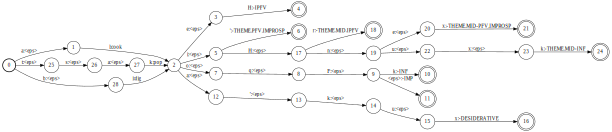

In [9]:
translateFST.draw("translate.gv")
translateFST

Draw the FST transitions for the morphological decomposition graph

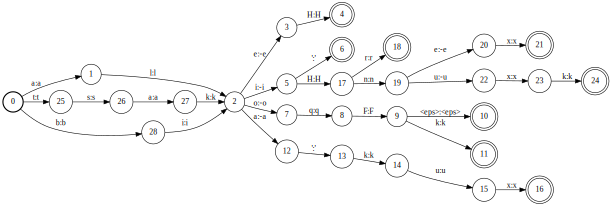

In [10]:
morphFST.draw("morph.gv")
morphFST

Step 8: Generate PDF and download first file.

(This works for Google Chrome. Read here:
https://stackoverflow.com/questions/48774285/how-to-download-file-created-in-colaboratory-workspace ). If you are working from a different browser, you can still download the file by clicking on the folder icon from Google Colab (left panel, fourth button from the top down).

In [11]:
render('dot','pdf','translate.gv')
files.download('translate.gv.pdf')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Generate PDF and download second file.


In [12]:
render('dot','pdf','morph.gv')
files.download('morph.gv.pdf')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>